In [ ]:
import os
import torch
import sys
import re
import glob
import random
import numpy as np
import pandas as pd
import scanpy as sc
from PIL import Image
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.spatial.distance import cdist
import torchvision.transforms as T
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import logging
import h5py
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# read h5 metadata
with h5py.File("/home/hongyi/project/HEST/hest_data/patches/TENX13.h5", "r") as f:
    raw_barcodes = f["barcode"][:]
    coords_all   = f["coords"][:]
    n_total      =f["img"][:].shape[0]

barcodes = [b.decode("utf-8") if isinstance(b, bytes) else b for b in raw_barcodes.flatten()]

# read AnnData & QC
adata = sc.read_h5ad("/home/hongyi/project/HEST/hest_data/st/TENX13.h5ad")
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Only keep valid barcodes and corresponding coordinates
valid_barcodes = [bc for bc in barcodes if bc in adata.obs_names]
adata_sub = adata[valid_barcodes].copy()

matched_indices = [i for i, bc in enumerate(barcodes) if bc in adata_sub.obs_names]
barcodes = [barcodes[i] for i in matched_indices]
coords = coords_all[matched_indices]

# Ensure gene expression is in the same order
barcode_idx = [adata_sub.obs_names.get_loc(bc) for bc in barcodes]
gene_exp = adata_sub.X[barcode_idx].astype(np.float32)
gene_name = adata_sub.var_names
if not isinstance(gene_exp, np.ndarray):
    gene_exp = gene_exp.toarray()

# Select 250 genes by mean expression
gene_means = gene_exp.mean(axis=0)  # shape: (num_genes,)
top_k = 250
top_gene_indices = np.argsort(gene_means)[-top_k:]
gene_exp_top = gene_exp[:, top_gene_indices]  # shape: (num_spots, 250)
gene_names_top = gene_name[top_gene_indices]

# Reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


def numerical_sort_key(filename):
    m = re.search(r'(\d+)', os.path.basename(filename))
    return int(m.group(1)) if m else -1

# Build ordered image list and align labels
image_dir = '/home/hongyi/project/HEST/hest_patches/TENX13'
all_images = sorted(glob.glob(os.path.join(image_dir, '*.png')), key=numerical_sort_key)
id2pos = {idx: pos for pos, idx in enumerate(matched_indices)}

images_ordered, pos_order = [], []
for p in all_images:
    n = numerical_sort_key(p)
    if n in id2pos:
        images_ordered.append(p)
        pos_order.append(id2pos[n])

images = images_ordered
gene_exp_top = gene_exp_top[pos_order]          # reorder labels to match images
coords = coords[pos_order]
barcodes_matched = [barcodes[i] for i in pos_order]

# --------------- Randomly split datasets ---------------
TRAIN_SPLIT  = 0.30
VAL_SPLIT    = 0.20

num_samples = len(gene_exp_top)
indices = np.arange(num_samples)
np.random.seed(SEED)
np.random.shuffle(indices)

train_size = int(num_samples * TRAIN_SPLIT)
val_size = int(num_samples * VAL_SPLIT)
test_size = num_samples - val_size - train_size

train_idx, val_idx, test_idx = (
    indices[:train_size],
    indices[train_size:train_size+val_size],
    indices[train_size+val_size:]
)

/home/hongyi/miniconda3/envs/llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
Y_pred = pd.read_csv("/home/hongyi/project/Pred_Results/TENX13/TENX13_SNR_pred.csv", index_col=0).values

In [4]:
assert Y_pred.shape == gene_exp_top.shape, \
    f"shape mismatch: pred {Y_pred.shape} vs GT {gene_exp_top.shape}"

resid = gene_exp_top - Y_pred                      # (N, G)
mse_per_gene = (resid ** 2).mean(axis=0)           # (G,)
mae_per_gene = np.abs(resid).mean(axis=0)   

metrics = pd.DataFrame({
    "gene": np.asarray(gene_names_top),
    "MSE": mse_per_gene,
    "MAE": mae_per_gene,
    "Var_GT": gene_exp_top.var(axis=0),
    "Mean_GT": gene_exp_top.mean(axis=0),
})
metrics_sorted = metrics.sort_values("MSE", ascending=True).reset_index(drop=True)

print("Top 10 genes (lowest MSE):")
print(metrics_sorted.head(10))


Top 10 genes (lowest MSE):
     gene       MSE       MAE    Var_GT   Mean_GT
0   RPLP1  0.054226  0.171445  0.077154  3.927476
1   RPL41  0.054302  0.180388  0.067547  4.219973
2   RPL13  0.058301  0.181679  0.076005  3.624375
3   SERF2  0.063126  0.191547  0.065714  3.443382
4   RPS27  0.063586  0.187416  0.080881  3.703717
5   RPS18  0.072199  0.197124  0.080696  3.392469
6   RPL28  0.072576  0.198211  0.078300  3.277874
7  TMSB10  0.073112  0.209330  0.096509  3.616250
8   KRT19  0.076204  0.203924  0.124578  4.070019
9   RPL36  0.076379  0.210869  0.114076  3.012576


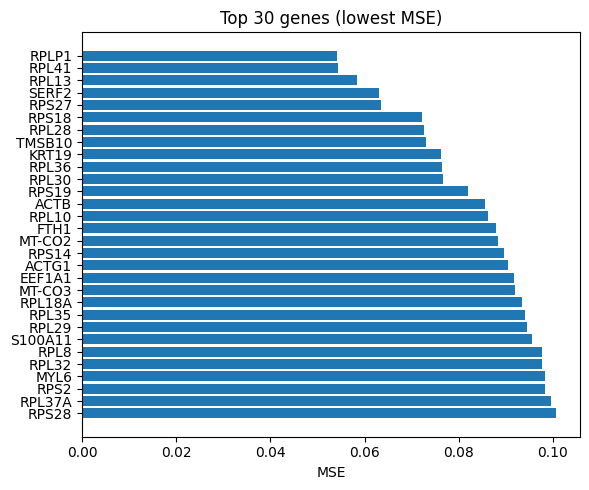

In [5]:
import matplotlib.pyplot as plt

topn = 30
sub = metrics_sorted.head(topn).iloc[::-1]  # reverse so best is at bottom

plt.figure(figsize=(6, 5))
plt.barh(sub["gene"], sub["MSE"])
plt.xlabel("MSE")
plt.title(f"Top {topn} genes (lowest MSE)")
plt.tight_layout()
plt.show()


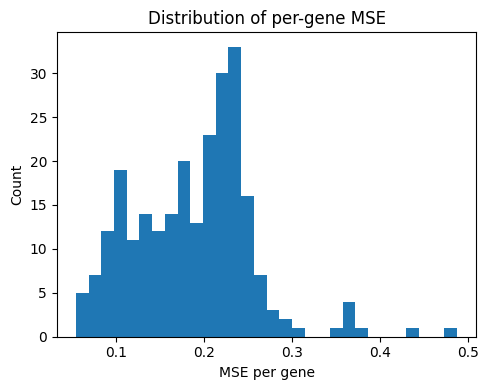

In [6]:
plt.figure(figsize=(5, 4))
plt.hist(metrics_sorted["MSE"], bins=30)
plt.xlabel("MSE per gene")
plt.ylabel("Count")
plt.title("Distribution of per-gene MSE")
plt.tight_layout()
plt.show()

In [7]:
nomixup_pred = pd.read_csv("/home/hongyi/project/Pred_Results/TENX13/TENX13_raw_pred.csv", index_col=0).values
basic_pred = pd.read_csv("/home/hongyi/project/Pred_Results/TENX13/TENX13_basic_pred.csv", index_col=0).values
mixup_pred = pd.read_csv("/home/hongyi/project/Pred_Results/TENX13/TENX13_mixup_pred.csv", index_col=0).values
cutmix_pred = pd.read_csv("/home/hongyi/project/Pred_Results/TENX13/TENX13_cutmix_pred.csv", index_col=0).values

## Compare to CutMix

In [ ]:
# Sanity checks
assert Y_pred.shape == cutmix_pred.shape == gene_exp_top.shape, \
    f"Shape mismatch: {Y_pred.shape}, {cutmix_pred.shape}, {gene_exp_top.shape}"

# Compute per-gene MSEs
mse_cut = ((cutmix_pred - gene_exp_top) ** 2).mean(axis=0)   # cutmix
mse_snr = ((Y_pred - gene_exp_top) ** 2).mean(axis=0)   # SNR
genes = np.asarray(gene_names_top)

# Compare
mse_diff = mse_cut - mse_snr     # positive means ours better

metrics_cmp = pd.DataFrame({
    "gene": genes,
    "MSE_Ours": mse_snr,
    "MSE_CutMix": mse_cut,
    "Diff": mse_diff,             # >0 means ours better
}).sort_values("Diff", ascending=False).reset_index(drop=True)

# Identify much better genes
threshold = 0.02
better_genes = metrics_cmp[metrics_cmp["Diff"] > threshold]
print(f"{len(better_genes)} genes where ours outperforms CutMix by >{threshold:.3f} MSE")
print(better_genes.head(20))

142 genes where ours outperforms CutMix by >0.020 MSE
      gene  MSE_Ours  MSE_CutMix      Diff
0    IGHG1  0.384115    0.447503  0.063388
1    IGLC2  0.487059    0.544555  0.057496
2   MT-ND2  0.149163    0.205547  0.056383
3      MGP  0.242434    0.296549  0.054115
4   COL1A2  0.345965    0.398680  0.052715
5   COL1A1  0.358248    0.408063  0.049814
6   RPL36A  0.245526    0.295103  0.049577
7     TFF3  0.214836    0.263992  0.049155
8   MT-CO1  0.120143    0.167784  0.047641
9     APOE  0.200250    0.247543  0.047293
10  MT-CO3  0.091912    0.137231  0.045319
11   IGHG4  0.313898    0.358727  0.044830
12  CALML5  0.209737    0.253375  0.043638
13    MUC1  0.139832    0.183398  0.043567
14     VIM  0.295753    0.338997  0.043244
15   COX6C  0.102672    0.145219  0.042547
16  IGFBP7  0.361311    0.403400  0.042089
17  IGFBP5  0.118272    0.160143  0.041871
18    IGKC  0.439978    0.481724  0.041746
19  MT-CYB  0.115500    0.156535  0.041036


## Compare to Mixup

In [ ]:
# Compute per-gene MSEs
mse_mix = ((mixup_pred - gene_exp_top) ** 2).mean(axis=0)   # mixup
mse_snr = ((Y_pred - gene_exp_top) ** 2).mean(axis=0)   # SNR
genes = np.asarray(gene_names_top)

# Compare
mse_diff = mse_mix - mse_snr     # positive means ours better

metrics_cmp = pd.DataFrame({
    "gene": genes,
    "MSE_Ours": mse_snr,
    "MSE_Mixup": mse_mix,
    "Diff": mse_diff,             # >0 means ours better
}).sort_values("Diff", ascending=False).reset_index(drop=True)

# Identify much better genes
threshold = 0.04
better_genes = metrics_cmp[metrics_cmp["Diff"] > threshold]
print(f"{len(better_genes)} genes where ours outperforms Mixup by >{threshold:.3f} MSE")
print(better_genes.head(20))

21 genes where ours outperforms Mixup by >0.040 MSE
       gene  MSE_Ours  MSE_Mixup      Diff
0      IGKC  0.439978   0.504506  0.064528
1     CRIP1  0.249687   0.306999  0.057312
2     IGHG1  0.384115   0.440033  0.055919
3      BST2  0.249661   0.304783  0.055122
4     IGHG3  0.367903   0.421992  0.054088
5       MGP  0.242434   0.295036  0.052602
6   MORF4L2  0.240539   0.291567  0.051028
7    COL1A2  0.345965   0.396168  0.050203
8      APOE  0.200250   0.250033  0.049783
9     ISG15  0.178438   0.227578  0.049140
10    IGLC2  0.487059   0.535878  0.048818
11   RPL10A  0.210861   0.257564  0.046703
12      VIM  0.295753   0.340818  0.045065
13    IFI27  0.150468   0.195511  0.045043
14   IGFBP7  0.361311   0.404593  0.043282
15   TCEAL4  0.222041   0.264806  0.042765
16   MT-ND3  0.129686   0.172255  0.042568
17  HLA-DRA  0.228459   0.268870  0.040412
18   MT-ND1  0.129283   0.169673  0.040390
19   CALML5  0.209737   0.249978  0.040241


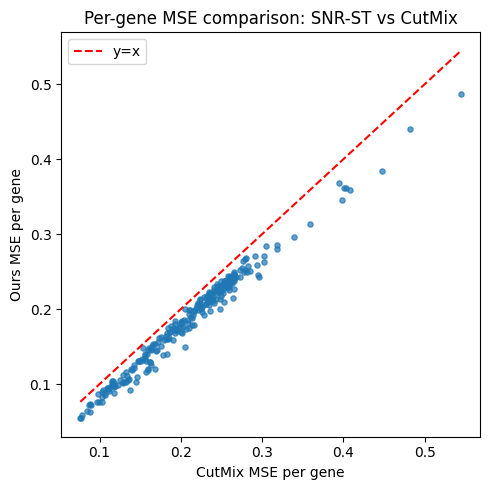

In [10]:
plt.figure(figsize=(5,5))
plt.scatter(mse_cut, mse_snr, s=14, alpha=0.7)
plt.plot([mse_cut.min(), mse_cut.max()],
         [mse_cut.min(), mse_cut.max()],
         "r--", label="y=x")
plt.xlabel("CutMix MSE per gene")
plt.ylabel("Ours MSE per gene")
plt.title("Per-gene MSE comparison: SNR-ST vs CutMix")
plt.legend()
plt.tight_layout()
plt.show()


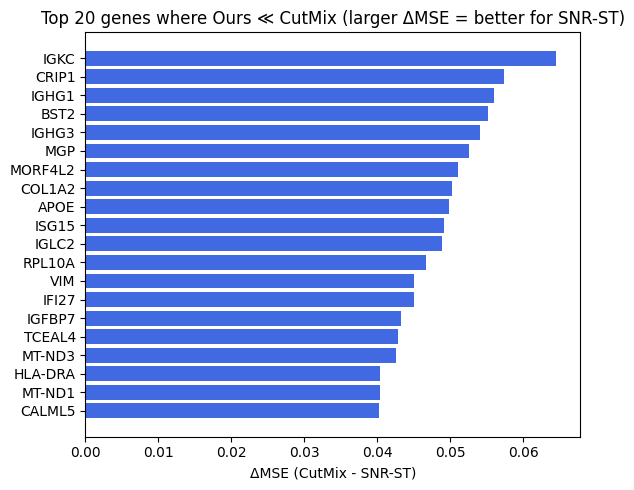

In [11]:
topn = 20
top_diff = metrics_cmp.head(topn).iloc[::-1]  # reverse for better ordering

plt.figure(figsize=(6,5))
plt.barh(top_diff["gene"], top_diff["Diff"], color="royalblue")
plt.xlabel("ΔMSE (CutMix - SNR-ST)")
plt.title(f"Top {topn} genes where Ours ≪ CutMix (larger ΔMSE = better for SNR-ST)")
plt.tight_layout()
plt.show()


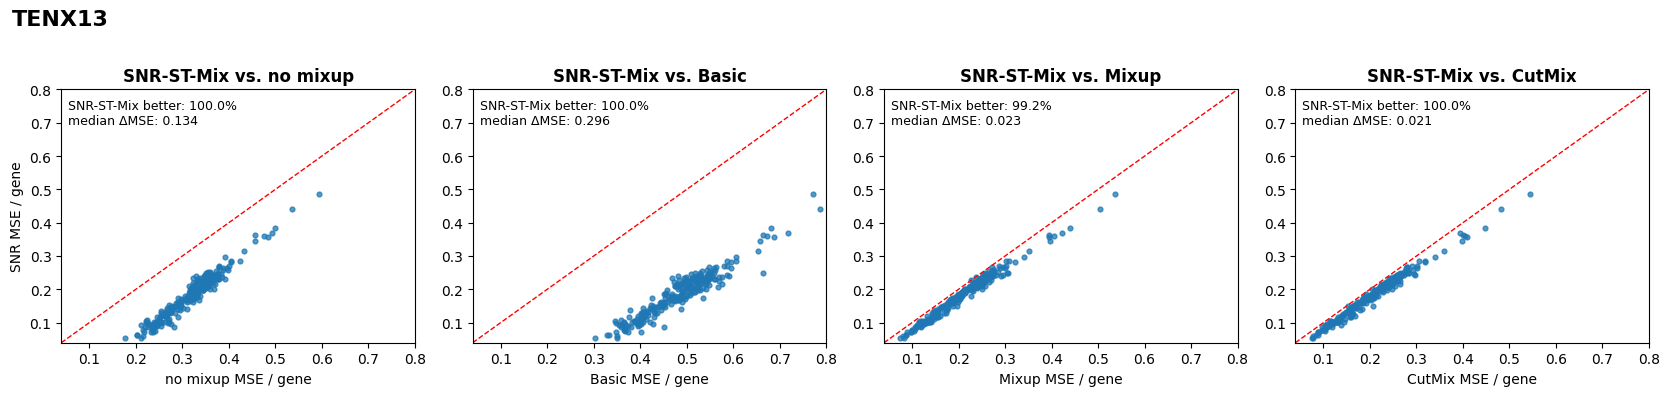

     method  frac_genes_SNR_better  median_diff_MSE  mean_diff_MSE
0  no mixup                  1.000         0.133925       0.133370
1     Basic                  1.000         0.296167       0.296362
3    CutMix                  1.000         0.021044       0.023546
2     Mixup                  0.992         0.022638       0.024531


In [ ]:
methods_pred = {
    "no mixup": nomixup_pred,   # (N, G)
    "Basic":    basic_pred,
    "Mixup":    mixup_pred,
    "CutMix":   cutmix_pred,   
}

# compute per-gene MSEs
mse_snr = ((Y_pred - gene_exp_top) ** 2).mean(axis=0)  # (G,)

mse_by_method = {}
for name, P in list(methods_pred.items()):
    if P is None:
        methods_pred.pop(name)
        continue
    assert P.shape == gene_exp_top.shape, f"{name} shape mismatch"
    mse_by_method[name] = ((P - gene_exp_top) ** 2).mean(axis=0)  # (G,)

# shared axis limits across all subplots
all_x = np.concatenate([m for m in mse_by_method.values()]) if mse_by_method else mse_snr
lo = float(min(all_x.min(), mse_snr.min()))
hi = float(max(all_x.max(), mse_snr.max()))
pad = 0.02 * (hi - lo + 1e-12)
xmin, xmax = lo - pad, hi + pad
ymin, ymax = xmin, xmax  # same range for fair diagonal

K = len(mse_by_method)
fig, axes = plt.subplots(1, K, figsize=(4.2*K, 4), squeeze=False)
axes = axes[0]

summary_rows = []
for i, (name, mse_x) in enumerate(mse_by_method.items()):
    ax = axes[i]
    ax.scatter(mse_x, mse_snr, s=12, alpha=0.75)
    ax.plot([xmin, xmax], [ymin, ymax], "r--", lw=1, label="y=x")

    # Fraction of genes where SNR is better, and median ΔMSE
    diff = mse_x - mse_snr
    frac_better = (diff > 0).mean()  # SNR better when method MSE > SNR MSE
    med_diff = np.median(diff)
    ax.text(0.02, 0.96,
            f"SNR-ST-Mix better: {100*frac_better:.1f}%\nmedian ΔMSE: {med_diff:.3f}",
            transform=ax.transAxes, va="top", ha="left", fontsize=9,
            bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.8, lw=0))

    ax.set_title(f"SNR-ST-Mix vs. {name}", fontweight="bold")
    ax.set_xlabel(f"{name} MSE / gene")
    if i == 0:
        ax.set_ylabel("SNR MSE / gene")
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    summary_rows.append({
        "method": name,
        "frac_genes_SNR_better": frac_better,
        "median_diff_MSE": med_diff,
        "mean_diff_MSE": diff.mean()
    })

#plt.tight_layout()
fig.suptitle("TENX13",
             fontsize=16, fontweight="bold", x=0.01, ha="left")
plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()

summary_df = pd.DataFrame(summary_rows).sort_values("frac_genes_SNR_better", ascending=False)
print(summary_df)